In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME ='cs231n/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment2/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment2


In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


In [4]:
!nvidia-smi

Sat Mar 19 16:31:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
import torch.nn.functional as F

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [7]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [8]:
from tqdm import tqdm
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in tqdm(enumerate(loader_train)):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

                # if t % print_every == 0:
            # print('Iteration %d, loss = %.4f' % (t, loss.item()))
        check_accuracy_part34(loader_val, model)
        print()

In [9]:
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

channels = [64, 128, 256]

num_filters = [3, 3, 3]

class VGG16(nn.Module):
  def __init__(self):
        super(VGG16, self).__init__()
        self.internal_model = nn.Sequential(

        nn.Conv2d(3, 64, 3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, padding='same'),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, 3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, padding='same'),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, 3, padding='same'),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding='same'),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding='same'),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512, 512, 3, padding='same'),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        Flatten(),
        nn.Dropout(),
        nn.Linear(1*1*512, 512), 
        nn.BatchNorm1d(512),
        nn.Linear(512, 10)
      )
        
  def forward(self, x):
    return self.internal_model(x)

In [ ]:
optimizer = None

learning_rate = 1e-2
vgg16 = VGG16()
optimizer = optim.SGD(vgg16.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
                     
train_part34(vgg16, optimizer, epochs=10)

In [ ]:
best_model = vgg16
check_accuracy_part34(loader_test, best_model)

In [ ]:
torch.save({
            'vgg16_state_dict': best_model.state_dict(),
            'optimizerA_state_dict': optimizer.state_dict()
            }, './vgg16.model')

In [11]:
loadedModel = VGG16()
learning_rate = 1e-2
loadedOptimizer = optim.SGD(loadedModel.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

checkpoint = torch.load('./vgg16.model')
loadedModel.load_state_dict(checkpoint['vgg16_state_dict'])
loadedOptimizer.load_state_dict(checkpoint['optimizerA_state_dict'])

In [77]:
loadedModel.to(device)
loadedModel.eval()
check_accuracy_part34(loader_test, loadedModel)

Checking accuracy on test set
Got 8219 / 10000 correct (82.19)


In [70]:
cifar10_example = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_example = DataLoader(cifar10_example, batch_size=10)

Files already downloaded and verified


In [71]:
if loader_example.dataset.train:
        print('Checking accuracy on validation set')
else:
    print('Checking accuracy on test set')   
num_correct = 0
num_samples = 0
loadedModel.eval()  # set model to evaluation mode
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
y_test = np.array([]) 
X_test = []
y_test_pred = np.array([]) 
with torch.no_grad():
    for x, y in loader_example:
        x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
        y = y.to(device=device, dtype=torch.long)
        scores = loadedModel(x)
        _, preds = scores.max(1)
        X_test.append(x.cpu().detach().numpy())
        y_test = np.append(y_test,  y.cpu().detach().numpy() )
        y_test_pred = np.append(y_test_pred, preds.cpu().detach().numpy() ) 
 
X_test = np.array(X_test)

print(X_test.shape)
print(y_test.shape)
print(y_test_pred.shape)

Checking accuracy on test set
(1000, 10, 3, 32, 32)
(10000,)
(10000,)


In [72]:
X_test = X_test.reshape((10000, 3, 32, 32)).transpose(0,2,3,1).astype("float")
print(X_test.shape)


(10000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

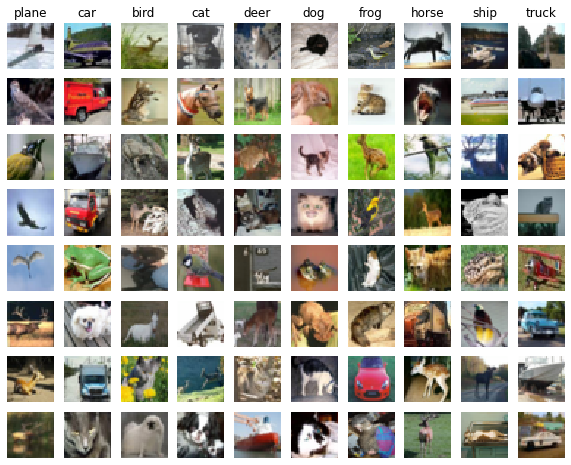

In [76]:
means = np.array([0.4914, 0.4822, 0.4465])
stds =  np.array([0.2023, 0.1994, 0.2010])

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow((X_test[idx] * stds + means))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()